<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/time_series_forecasting/4_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Author: Ann Weitz

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, LSTM, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import Model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import os

context_window = 336
prediction_horizon = 96
variable_column = ["temp", "o3"]
#variable_column = ["temp"]
future_covariates = ["temp"]

In [2]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

In [11]:
# Function from Notebook 3, adapted to multivariate data
# Function to create continous time-series data with past 24 hours as input and next 6 hours as output
def create_sequences(data, feature_columns, n_past=336, n_future=96):
    df = data.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values(['station_code', 'datetime']).reset_index(drop=True)

    # 1) Encode station_code as a small integer (categorical codes) to save memory
    df['sc_code'] = df['station_code'].astype('category')

    # 2) Boolean mask: True if exactly 1 hour after the previous row (per station)
    is1h = (
        df.groupby('station_code')['datetime']
          .diff()
          .eq(pd.Timedelta(hours=1))
    )

    # 3) Compute how many consecutive “True” over (n_past + n_future - 1) rows
    gap_window = n_past + n_future - 1
    run = (
        is1h.groupby(df['station_code'])
            .rolling(window=gap_window, min_periods=gap_window)
            .sum()
            .reset_index(level=0, drop=True)
    )

    # 4) 'ends' are indices where run == gap_window (end of a full-length continuous block)
    ends = run[run == gap_window].index

    # 5) Grab column‐arrays for encoded station code and all feature variables
    sc_arr  = df['sc_code'].values
    feature_arr = df[feature_columns].values
    full_input_df = pd.concat([df[['sc_code']], df[feature_columns]], axis=1)
    full_input = full_input_df.values

    X_list = []
    y_list = []
    for end_idx in ends:
        start_idx = end_idx - gap_window
        if start_idx >= 0 and sc_arr[start_idx] == sc_arr[end_idx]:
            block = full_input[start_idx : end_idx + 1]

            X_list.append(block[:n_past])
            y_list.append(block[n_past:])

    if not X_list:
        # No valid windows
        return np.empty((0, n_past, len(feature_columns)+1)), np.empty((0, n_future, len(feature_columns)+1))

    X = np.stack(X_list)  # shape = (num_windows, n_past, len(feature_columns)+1)
    y = np.stack(y_list)  # shape = (num_windows, n_future, len(feature_columns)+1)
    return X, y

In [4]:
# Mount google drive when working in colab
hasCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False
if hasCOLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  BASEPATH = '/content/drive/MyDrive'
else:
  BASEPATH = '.'

Mounted at /content/drive


In [30]:
# Load dataframe with normalized data from google drive
dataframe = pd.read_csv("/content/drive/MyDrive/timeseries_data/mv/normalized_data.csv")
print(dataframe.shape)
# Drop duplicates to get rid of duplicate time-stamps
dataframe.drop_duplicates(["datetime", "station_code"], inplace = True)
dataframe.head()

(440867, 6)


,longitude,latitude,station_code,datetime,o3,temp
0,6.093923,50.754704,DENW094,1997-01-01 00:00:00+00:00,-1.687797,-3.626220
1,6.093923,50.754704,DENW094,1997-01-01 01:00:00+00:00,-1.687797,-3.694622
2,6.093923,50.754704,DENW094,1997-01-01 02:00:00+00:00,-1.687797,-3.708302
3,6.093923,50.754704,DENW094,1997-01-01 03:00:00+00:00,-1.687797,-3.804064
4,6.093923,50.754704,DENW094,1997-01-01 04:00:00+00:00,-1.687797,-3.831425


In [31]:
# Create sequences from the dataframe and split them into train, test split
X, y = create_sequences(dataframe,variable_column,context_window,prediction_horizon)

train_size = int(len(X) * 0.7)
X_train_full, X_test_full = X[:train_size], X[train_size:]
y_train_full, y_test_full = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train_full.shape}, y_train shape: {y_train_full.shape}")
print(f"X_test shape: {X_test_full.shape}, y_test shape: {y_test_full.shape}")

X_train shape: (95970, 336, 3), y_train shape: (95970, 96, 3)
X_test shape: (41131, 336, 3), y_test shape: (41131, 96, 3)


In [32]:
# Get mean and std for target variable (o3)
target_idx = variable_column.index("o3")
dataframe = pd.read_csv("/content/drive/MyDrive/timeseries_data/mv/raw_data.csv")
scaler_stats = {col: {'mean': dataframe[col].mean(), 'std': dataframe[col].std()} for col in variable_column}
print(scaler_stats)

# Drop the dimension containing the station code
X_train = X_train_full[:,:,1:].copy()
X_test = X_test_full[:,:,1:].copy()

# Extract the future covariates from the target data
future_covariate_indices = [1 + variable_column.index(c) for c in future_covariates]
X_train_future = y_train_full[:, :, future_covariate_indices]
X_test_future = y_test_full[:,  :, future_covariate_indices]

# Drop the other variables, that are not the target variable
y_train = y_train_full[:,:,1+target_idx].copy()
y_test = y_test_full[:,:,1+target_idx].copy()

# Reshape to stack both variable dimensions into one
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Convert to floats
X_train = np.array(X_train, dtype=np.float32)
X_test  = np.array(X_test,  dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test  = np.array(y_test,  dtype=np.float32)
X_train_future = np.array(X_train_future, dtype = np.float32)
X_test_future = np.array(X_test_future, dtype = np.float32)


print(f"X_train shape: {X_train.shape}, X_train_future shape: {X_train_future.shape} ,y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, X_test_future shape: {X_test_future.shape},  y_test shape: {y_test.shape}")

{'temp': {'mean': np.float64(10.656768563895323), 'std': 7.309752136488672}, 'o3': {'mean': np.float64(24.586900674611172), 'std': 14.567449924073065}}
X_train shape: (95970, 672), X_train_future shape: (95970, 96, 1) ,y_train shape: (95970, 96)
X_test shape: (41131, 672), X_test_future shape: (41131, 96, 1),  y_test shape: (41131, 96)


In [16]:
## Remember the checkpoints made available are trained with below hyper params
# If changed you will have to retrain loading appropriate inputs like eg. loss
mlp_hidden_units = [128, 64, 32, 16]
mlp_epochs = 5
mlp_batch_size = 16
activation_fn='relu'
mlp_optim = 'adam'
mlp_loss = 'mse'

In [18]:
# Input dimensions for first MLP layer
input_dim_past = X_train.shape[1]
input_dim_future = X_train_future.shape[1:]
output_dim = y_train.shape[1]

# Input layers
input_past = Input((input_dim_past,), name = "past_input")
input_future = Input((input_dim_future), name ="input_future")

In [35]:
checkpoint_dir = "./checkpoint/"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "mlp_mv_future_covariates.keras")

# Input dimensions for first MLP layer
input_dim_past = X_train.shape[1]
input_dim_future = X_train_future.shape[1:]
output_dim = y_train.shape[1]

# Build a functional keras model
# 1: Input layers
input_past = Input((input_dim_past,), name = "past_input")
input_future = Input((input_dim_future), name ="input_future")

# 2: Processing of past stream
x = input_past
x = Dense(512, activation = "relu")(x)
x = Dense(256, activation = "relu")(x)

# 3: Processing of future stream
f = Flatten()(input_future)

# 4: Concatenation
h = Concatenate()([x,f])
h = Dense(256, activation = activation_fn)(h)
h = Dense(128, activation = activation_fn)(h)

# 5: Output
out = Dense((output_dim), activation="linear", name = "o3_forecast")(h)

# Build and compile the model
model = Model([input_past, input_future], out)

model.compile(optimizer = mlp_optim, loss = mlp_loss)
checkpoint_callback = ModelCheckpoint(
    checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ past_input          │ (None, 672)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 512)       │    344,576 │ past_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_future        │ (None, 96, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 256)       │    131,328 │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 96)        │          0 │ input_future[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 352)       │          0 │ dense_21[0][0],   │
│ (Concatenate)       │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 256)       │     90,368 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 128)       │     32,896 │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ o3_forecast (Dense) │ (None, 96)        │     12,384 │ dense_23[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 611,552 (2.33 MB)

 Trainable params: 611,552 (2.33 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Train model
training = model.fit(
    [X_train, X_train_future], y_train,
    epochs=mlp_epochs, batch_size=mlp_batch_size,
    validation_split=0.2, verbose=1,
    callbacks=[checkpoint_callback]
)
training_history = training.history

Epoch 1/5
4797/4799 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5324
Epoch 1: val_loss improved from inf to 0.41623, saving model to ./checkpoint/mlp_mv.keras
4799/4799 ━━━━━━━━━━━━━━━━━━━━ 59s 12ms/step - loss: 0.5324 - val_loss: 0.4162
Epoch 2/5
4796/4799 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4121
Epoch 2: val_loss improved from 0.41623 to 0.41597, saving model to ./checkpoint/mlp_mv.keras
4799/4799 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - loss: 0.4121 - val_loss: 0.4160
Epoch 3/5
4792/4799 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3715
Epoch 3: val_loss did not improve from 0.41597
4799/4799 ━━━━━━━━━━━━━━━━━━━━ 78s 9ms/step - loss: 0.3714 - val_loss: 0.4375
Epoch 4/5
4793/4799 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3443
Epoch 4: val_loss did not improve from 0.41597
4799/4799 ━━━━━━━━━━━━━━━━━━━━ 48s 10ms/step - loss: 0.3443 - val_loss: 0.4356
Epoch 5/5
4793/4799 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3203
Epoch 5: val_loss did not improve from 0.41597
4799/4799 ━━━━━━━━━

In [37]:
# Make predictions with the model for evaluation
y_pred = model.predict([X_test, X_test_future])

# Evaluate the model
evaluate_model(y_test, y_pred)

1286/1286 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
RMSE: 0.6693


np.float64(0.6693433704970885)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


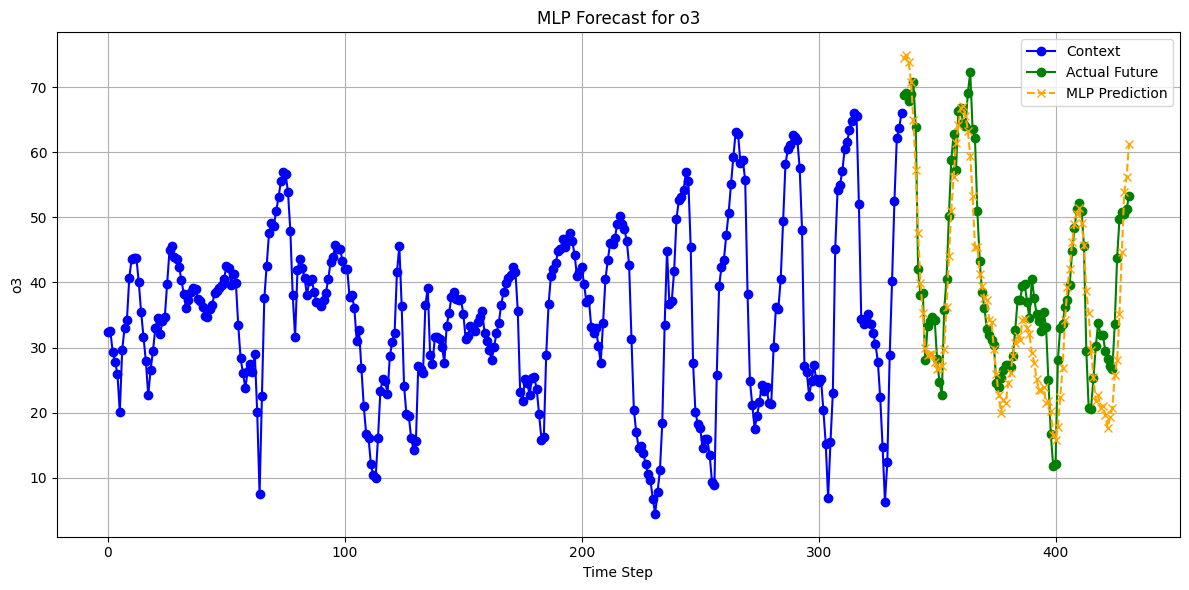

In [39]:
target_idx = 1
target_var = variable_column[target_idx] # for o3

# Load trained model checkpoint (best validation loss)
mlp_model = load_model(
    os.path.join(checkpoint_dir, f"mlp_mv_future_covariates.keras"),
    custom_objects={"mse": MeanSquaredError()}
)

# Pick a sample from the test data
sample_idx = 42
X_test_sample = X_test[sample_idx]
X_test_future_sample = X_test_future[sample_idx]
y_test_sample = y_test[sample_idx]

# Predict
mlp_pred_sample = mlp_model.predict([X_test_sample.reshape(1, -1),
                                     X_test_future_sample.reshape(1, *X_test_future[sample_idx].shape)]).flatten()

# Get context portion (most recent history of the target variable)
X_test_reshaped = X_test_sample.reshape(context_window, len(variable_column))  # shape: (336, 2)
context = X_test_reshaped[:, target_idx]

# Inverse scale
mean = scaler_stats[target_var]['mean']
std = scaler_stats[target_var]['std']

context_scaled = context * std + mean
actual_future = y_test_sample * std + mean
predicted_future = mlp_pred_sample * std + mean

# Plot
plt.figure(figsize=(12, 6))
plt.plot(range(context_window), context_scaled, label="Context", color="blue", marker="o")
plt.plot(range(context_window, context_window + prediction_horizon), actual_future, label="Actual Future", color="green", marker="o")
plt.plot(range(context_window, context_window + prediction_horizon), predicted_future, label="MLP Prediction", linestyle="--", color="orange", marker="x")

plt.title(f"MLP Forecast for {target_var}")
plt.xlabel("Time Step")
plt.ylabel(target_var)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
# Save the timeseries and results for visualization and comparison against other models
X_test_sample_df = pd.DataFrame({
    "timestep": range(0,context_window),
    "value": context_scaled
})
y_test_sample_df = pd.DataFrame({
    "timestep": range(context_window, context_window + prediction_horizon),
    "value": actual_future
})

sample_df = pd.concat([X_test_sample_df, y_test_sample_df])
sample_df.to_csv("/content/drive/MyDrive/timeseries_data/mv/sample_future_covariates.csv", index = False)

In [41]:
mlp_results_mv = pd.DataFrame({
    "timestep": range(context_window, context_window + prediction_horizon),
    "value": predicted_future
})
mlp_results_mv.to_csv("/content/drive/MyDrive/timeseries_data/mv/mlp_covariates_results_mv.csv", index = False)

This notebook is an attempt at performing multivariate time series forecasting with known future covariates. It uses the same data, that notebook 9, the simple multivariate MLP uses.

The main difference is already named in the title of this: using known future covariates of the target we're predicting. In this case, we have use past temperature and ozone data, as well as future temperature data, to predict the future ozone concentration.

The model is a bit more complex than the simple MLP used in the previous notebook. Both past and future data are fed to two different input layers. The past data has a slightly more complex path, by getting passed through some dense layers, before being concatenated with the flattened future data (Flattened, in case one would want to use multiple known covariates). After that, the data is passed through another two dense layers and then handed to an output layer with the future window we want to predict as no. of neurons.

This model also uses the functional API to build the model, in comparison to the Sequential model, that we built in the normal multivariate task.